Simulation Methodology:

The uniform distribtuion of $v \sim [0, \psi]$ is approximated by an evenly spaced mesh with the number of elements given by the paramter num_boxes. The coarsness if the mesh is given by the variable step_size .


For a given index i, g[i] is the number of consumer with valuation between step_size * i and step_size * i + 1 (the integral of g(v)). For the compution, all the consumers in g[i] are assumed to have valuation g[i] * step_size, the lower bound of the true range of valutions. Given a time and price, the variable integrate_from = $ \lceil \frac{p_t}{\text{a_t * self.step_size}} \rceil $ is the index starting from which the values of g[i] will be summed (this is appromxation to the integration used to obtain the quantity sold). 


In [1]:
% matplotlib inline
import numpy as np
import csv
import matplotlib.pyplot as plt

#This part reads the csv file with the data to create time, price, observed quantity 

pq_data = open('pqdata.csv','r')
t_val=[]
q_val = []
p_val = []
line = iter(pq_data)
line = next(line)
for line in pq_data:
   
    t, p, q = line.split(',')
    t_val.append(int(t))
    p_val.append(float(p))
    q_val.append(float(q))

#Create a class to represent the model    
class DVD_Bundling:
    def __init__(self, eta, phi, nu, psi, tau, omega, num_boxes, p_val):
        self.eta = eta # eta = population size
        self.phi = phi # phi = decision probability
        self.nu = nu   # nu = population "death" rate
        self.psi = psi # highest valuation in $
        self.tau = tau # week after which obsolescence begins
        self.omega = omega # limit of valuation discount rate
        self.num_boxes  = num_boxes
        self.v_values, self.step_size = np.linspace(0, self.psi, num = self.num_boxes, endpoint = False, retstep = True, dtype = float )
        self.f = 1/self.psi #uniform density
        self.g = []  # The number of people with a valuations in intervals corresponding to coarsness of mesh
        for i in range(0, self.num_boxes):
            self.g.append(self.eta * self.f * self.step_size) #number of people in each box of the approxmation for the g(v)
        self.q = [0]
        self.prices = p_val #price data
        
    def __g_update__(self, integrate_from): #This method computes the new g(v)
            
        for i in range (0, self.num_boxes): #When discounted valution less than the price (no purchases)
            if i < integrate_from:
                g_new = (1- self.nu) * self.g[i] + self.nu * self.eta * self.f * self.step_size
                self.g[i] = g_new
                
            else: #When discounted valuation exceeds price and some fraction purchase
                g_new = (1 - self.phi) *(1 - self.nu) * self.g[i] + self.nu * self.eta * self.f * self.step_size
                
                self.g[0] += (1 - self.phi) *(1 - self.nu) * self.g[i] #Those who have already purchased go to zero bucket
                self.g[i] = g_new
                    
        return None
        
    def __compute_q__(self, integrate_from): # This function approximated the integration used to obtain the quanity purchased
            
        q_t = 0.0 #initialize to zero (no buyers)
        if integrate_from > (self.num_boxes - 1): #if price were to exceed maximum valuation,then there would be no buyers
            pass
        else:
            for i in range(int(integrate_from), self.num_boxes):
                #print(i)
                q_t += self.g[i] #sum of conusmer that have valuation greater than bound for summation (appromxation to integration)
        return (q_t * self.phi) #multiply final resuly by phi, the awareness/probability of purchase parameter
        
    def __discount__(self, t):#This function computes the discount rate for each time value
             
        if t <= self.tau:
            a_t = 1
        else:
            a_t = self.omega + np.power((1 - self.omega), (t/self.tau))
            
        return a_t
        
    def __integrate_from__(self, p_t, a_t): #lower bound for 'integration'
            
        integrate_from = np.ceil(p_t/(a_t * self.step_size)) #converts from indexing by value to indexing by box number
        return integrate_from
        
    def simulate_path(self, time): #The main to generate model results
             
        for t in range(1, time): #time zero exclued
            p_t = self.prices[t]
            a_t = self.__discount__(t)
            integrate_from = self.__integrate_from__(p_t, a_t)
            self.__g_update__(integrate_from)
            q_t = self.__compute_q__(integrate_from)
            self.q.append(q_t)
        return self.q    
                
                    
                
            
            
            
            
                               
            
            
        
                    
                
                
                
            
        
            
            
            
        
        
    
        

In [2]:
test = DVD_Bundling(3000, .03,.005, 50, 3,  0.22, 10000, p_val)
test.__discount__(100)
test.prices[100]
test.__integrate_from__(10.0315, test.__discount__(100)) * test.step_size
test.step_size
x = test.simulate_path(260)



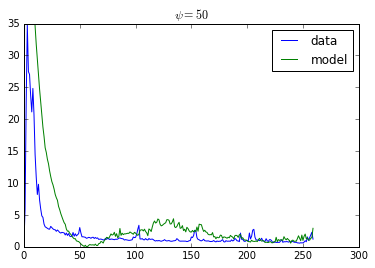

In [3]:
plt.plot(t_val, q_val, label = 'data')
plt.ylim(ymin = 0, ymax =35)
plt.plot(t_val, test.q , label = 'model')
plt.legend()
plt.title( "$\psi = 50$")
plt.show()

In [4]:
test_2 = DVD_Bundling(3000, .03,.005, 100, 3,  0.22, 10000, p_val)
y = test_2.simulate_path(260)

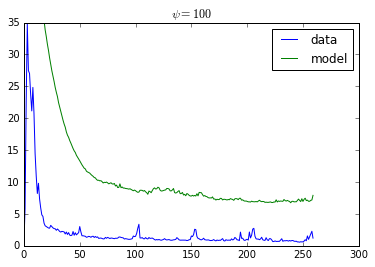

In [5]:
plt.plot(t_val, q_val, label = 'data')
plt.ylim(ymin = 0, ymax =35)
plt.plot(t_val, test_2.q , label = 'model')
plt.legend()
plt.title( "$\psi = 100$")
plt.show()